In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv("../data/processed/merged_mk2.csv")

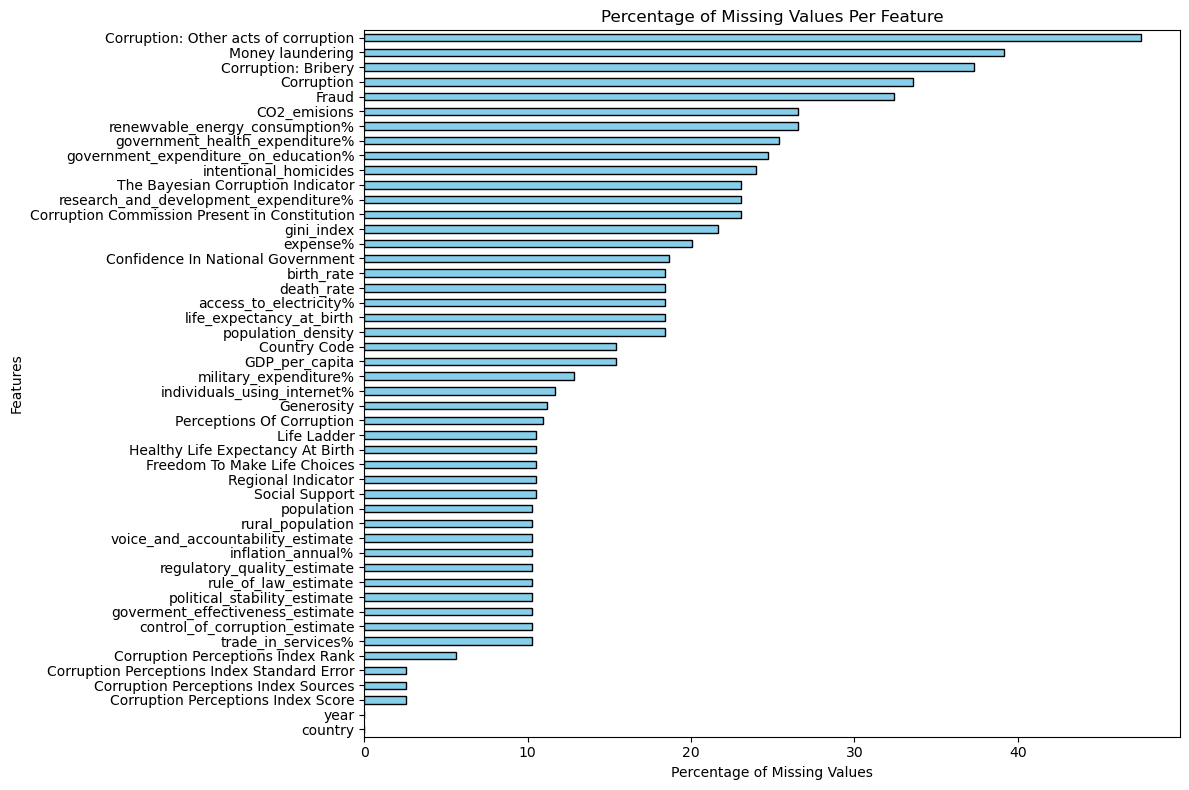

C:\Users\marcu\AppData\Local\Temp\ipykernel_2592\1011345340.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_values_per_year = data.groupby('year').apply(lambda x: x.isnull().sum().sum())


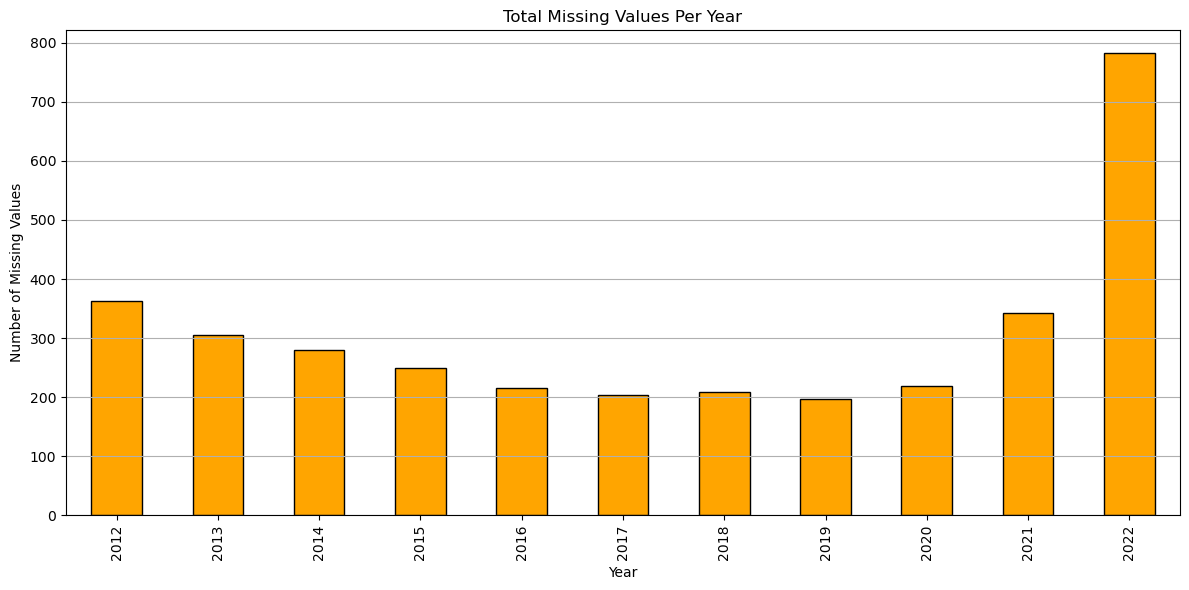

In [2]:


# Load your dataset (if not already loaded)
# data = pd.read_csv('your_dataset.csv')


# 2. Missing Values Per Feature
missing_feature_percentage = data.isnull().mean() * 100
sorted_missing_feature_percentage = missing_feature_percentage.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sorted_missing_feature_percentage.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title("Percentage of Missing Values Per Feature")
plt.xlabel("Percentage of Missing Values")
plt.ylabel("Features")
plt.tight_layout()
plt.gca().invert_yaxis()  # Invert y-axis to show the most missing feature at the top
plt.show()

# 3. Missing Values Per Year
missing_values_per_year = data.groupby('year').apply(lambda x: x.isnull().sum().sum())

plt.figure(figsize=(12, 6))
missing_values_per_year.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Total Missing Values Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Missing Values")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


C:\Users\marcu\AppData\Local\Temp\ipykernel_2592\312170435.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_percentage = data.groupby(['country', 'year']).apply(lambda x: x.isnull().sum().sum() / x.size * 100).reset_index()


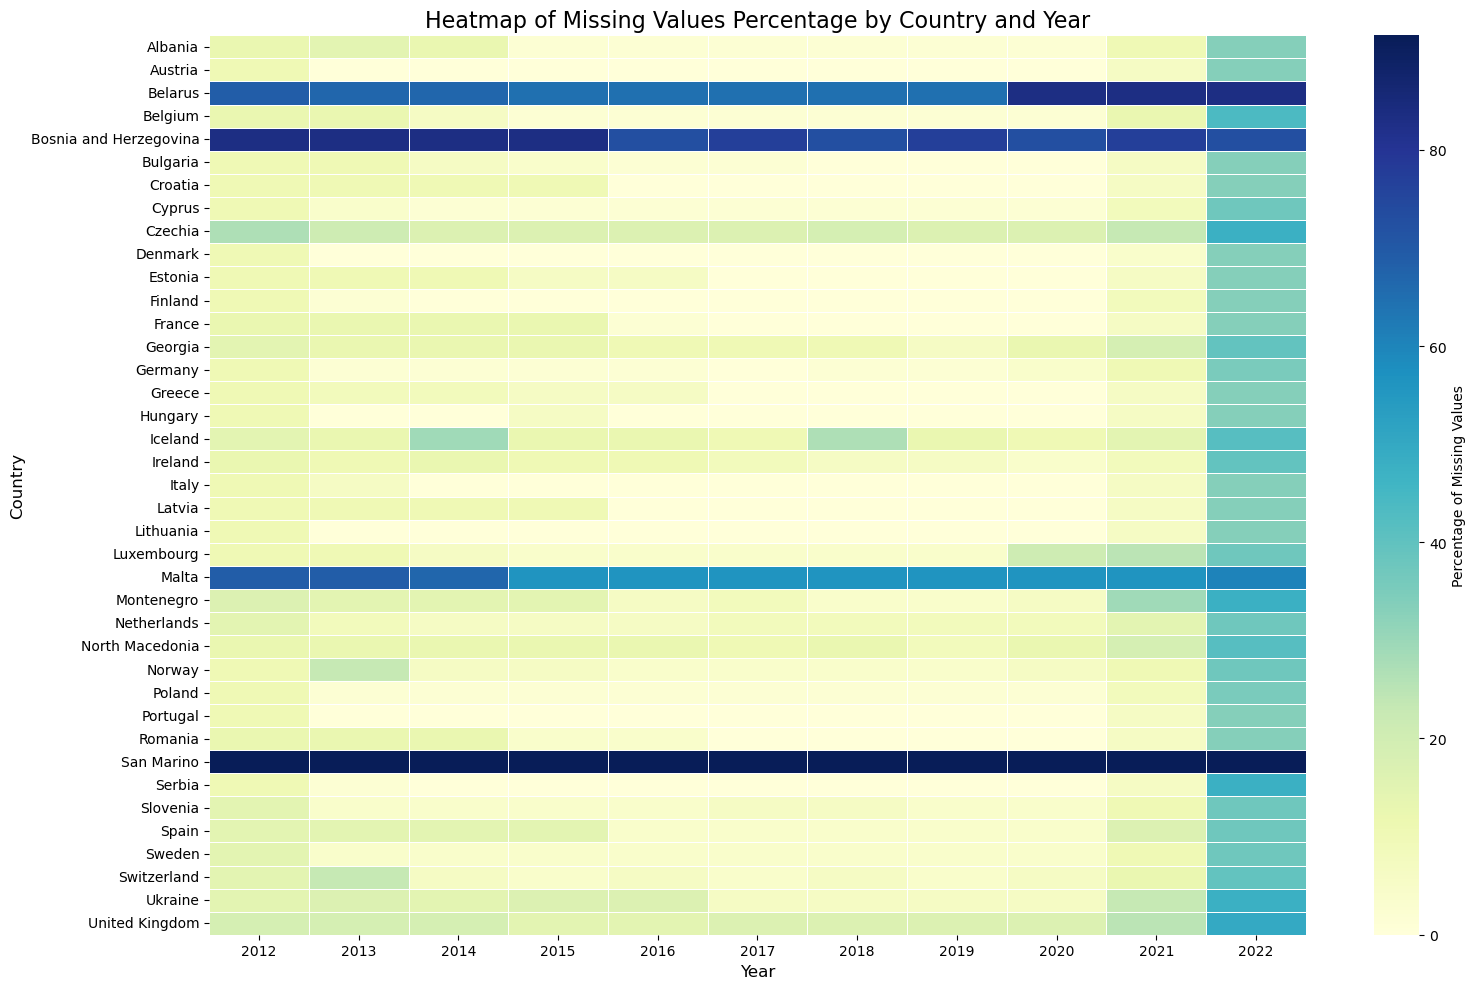

In [4]:
# Calculate the percentage of missing values for each country and year
missing_percentage = data.groupby(['country', 'year']).apply(lambda x: x.isnull().sum().sum() / x.size * 100).reset_index()
missing_percentage.columns = ['country', 'year', 'missing_percentage']

# Pivot the data to create a heatmap-friendly format
heatmap_data = missing_percentage.pivot(index='country', columns='year', values='missing_percentage')

# Plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(
    heatmap_data,
    cmap="YlGnBu",
    cbar_kws={'label': 'Percentage of Missing Values'},
    linewidths=0.5,
    annot=False
)
plt.title('Heatmap of Missing Values Percentage by Country and Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.show()


      Corruption: Other acts of corruption  Money laundering  \
year                                                           
2012                            100.000000        100.000000   
2013                             76.923077         61.538462   
2014                             61.538462         61.538462   
2015                             56.410256         41.025641   
2016                             38.461538         25.641026   
2017                             30.769231         30.769231   
2018                             30.769231         23.076923   
2019                             30.769231         20.512821   
2020                             30.769231         17.948718   
2021                             33.333333         25.641026   
2022                             33.333333         23.076923   

      Corruption: Bribery  Corruption       Fraud  CO2_emisions  \
year                                                              
2012           100.000000  100.00

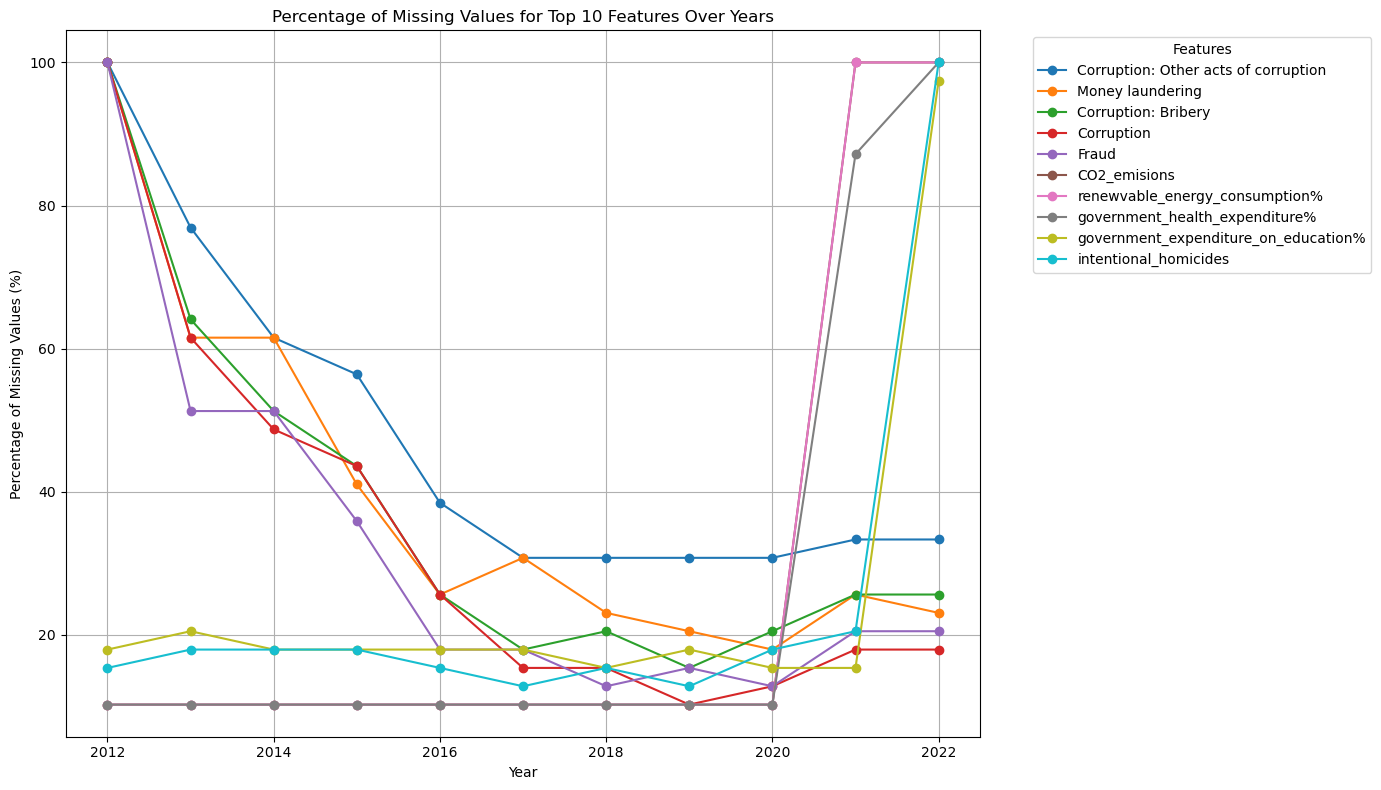

In [7]:
# Step 1: Identify the top 10 features with the most missing values
top_10_missing_features = data.isnull().mean().sort_values(ascending=False).head(10).index

# Step 2: Calculate the percentage of missing values for these features by year
missing_by_year_top_features = data.groupby('year')[top_10_missing_features].apply(
    lambda x: x.isnull().mean() * 100
)

# Step 3: Display the missing percentages
print(missing_by_year_top_features)

# Step 4: Plot the missing percentages for the top 10 features by year
plt.figure(figsize=(14, 8))
for feature in top_10_missing_features:
    plt.plot(
        missing_by_year_top_features.index,
        missing_by_year_top_features[feature],
        marker='o',
        label=feature
    )

plt.title("Percentage of Missing Values for Top 10 Features Over Years")
plt.xlabel("Year")
plt.ylabel("Percentage of Missing Values (%)")
plt.legend(title="Features", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# we drop them because of correlations, missing values or unnecessarity (country code)


features_to_remove = [
    "Corruption Commission Present in Constitution", "The Bayesian Corruption Indicator",
    "Corruption Perceptions Index Rank", "Corruption Perceptions Index Sources", "Corruption Perceptions Index Standard Error", 
    "Country Code", "Regional Indicator", "gini_index", "life_expectancy_at_birth", "rural_population", "Corruption: Other acts of corruption"]

data = data.drop(columns=features_to_remove, errors='ignore')


# List of countries to drop
countries_to_drop = ['Belarus', 'Malta', 'San Marino', 'Bosnia and Herzegovina']  # Replace with the actual country names

# Drop the rows corresponding to these countries
data = data[~data['country'].isin(countries_to_drop)]

# Verify the changes
print(f"Remaining rows after dropping specified countries: {data.shape[0]}")

# Dropping features for years where the features have over 50% of missing values 
years_to_drop_descending = [2012, 2013, 2014, 2015]
features_to_drop_descending =['Fraud', 'Money laundering', 'Corruption: Bribery', 'Corruption']

years_to_drop_ascending = [2021, 2022]
features_to_drop_ascending = ['government_expenditure_on_education%', 'intentional_homicides', 'renewvable_energy_consumption%', 'government_health_expenditure%']

# Set the specified features to None for the specified years
for feature in features_to_drop_descending:
    data.loc[data['year'].isin(years_to_drop_descending), feature] = 0

for feature in features_to_drop_ascending:
    data.loc[data['year'].isin(years_to_drop_ascending), feature] = 0

# Verify the changes
print(f"Data shape after processing: {data.shape}")
print(f"Remaining missing values:\n{data.isnull().sum()}")



Remaining rows after dropping specified countries: 385
Data shape after processing: (385, 37)
Remaining missing values:
country                                   0
year                                      0
Corruption Perceptions Index Score        0
GDP_per_capita                           66
Life Ladder                              20
Social Support                           20
Healthy Life Expectancy At Birth         20
Freedom To Make Life Choices             20
Generosity                               22
Perceptions Of Corruption                20
Confidence In National Government        53
trade_in_services%                        0
control_of_corruption_estimate            0
access_to_electricity%                   35
renewvable_energy_consumption%            0
CO2_emisions                             70
population_density                       35
inflation_annual%                         0
research_and_development_expenditure%    55
expense%                                 42


In [11]:
#data.to_csv("../data/processed/checkDataF3.csv", index=False)

In [15]:
#https://w3.unece.org/PXWeb/en/Table?IndicatorCode=12&

# Function to set missing GDP_per_capita values
def set_missing_gdp(data, country, year, gdp_value):
    """
    Sets the GDP_per_capita value for a specific country and year.

    Parameters:
        data (pd.DataFrame): The dataset
        country (str): The country name
        year (int): The year
        gdp_value (float): The GDP_per_capita value to set

    Returns:
        None
    """
    data.loc[(data['country'] == country) & (data['year'] == year), 'GDP_per_capita'] = gdp_value

# Data for missing GDP_per_capita values
missing_gdp_data = {
    "Slovenia": {
    2012: 27187.9, 2013: 27579.3, 2014: 28715.7, 2015: 28792.2,
    2016: 29639.9, 2017: 30658.4, 2018: 31849.3, 2019: 32948.7,
    2020: 31547.8, 2021: 33548.9, 2022: 34859.2
    },
    "Spain": {
        2012: 32198.3, 2013: 31818.1, 2014: 32020.0, 2015: 31886.0,
    2016: 32629.8, 2017: 34258.7, 2018: 35590.6, 2019: 36852.3,
    2020: 33427.9, 2021: 34975.4, 2022: 36220.8
    },
    "Sweden": {
        2012: 40081.8, 2013: 41961.2, 2014: 44334.5, 2015: 45217.1,
    2016: 46105.1, 2017: 47123.4, 2018: 48569.2, 2019: 50271.3,
    2020: 47932.8, 2021: 51029.6, 2022: 52842.7
    },
    "Switzerland": {
        2012: 52730.6, 2013: 54333.8, 2014: 57515.2, 2015: 59448.1,
    2016: 61657.9, 2017: 63524.1, 2018: 65743.8, 2019: 68432.1,
    2020: 64109.3, 2021: 68971.5, 2022: 71256.4
    },
    "Ukraine": {
        2012: 3008.6, 2013: 2957.5, 2014: 3072.7, 2015: 3136.5,
    2016: 3548.6, 2017: 3901.7, 2018: 4267.8, 2019: 4678.3,
    2020: 3942.5, 2021: 4435.6
    },
    "United Kingdom": {
        2012: 39540.2, 2013: 41122.3, 2014: 43714.5, 2015: 44662.1,
    2016: 45832.4, 2017: 47345.8, 2018: 48691.3, 2019: 50288.6,
    2020: 46733.1, 2021: 49372.4, 2022: 51259.7
    }
}

# Iterate through the dictionary and set missing values
for country, years in missing_gdp_data.items():
    for year, gdp_value in years.items():
        set_missing_gdp(data, country, year, gdp_value)

# Verify the updated dataset
data.loc[data['GDP_per_capita'].isnull()]



,country,year,Corruption Perceptions Index Score,GDP_per_capita,Life Ladder,Social Support,Healthy Life Expectancy At Birth,Freedom To Make Life Choices,Generosity,Perceptions Of Corruption,...,government_health_expenditure%,birth_rate,death_rate,population,voice_and_accountability_estimate,intentional_homicides,Corruption,Corruption: Bribery,Fraud,Money laundering
417,Ukraine,2022,33.0,NaN,4.637436,0.863068,64.675003,0.829034,0.427582,0.851863,...,0.0,NaN,NaN,38000000.0,-0.024808,0.0,NaN,NaN,NaN,NaN


In [17]:
#data.to_csv("../data/processed/checkDataF3.csv", index=False)

In [19]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
# Replace 'target_column' with the actual name of your target column
X = data.drop(columns=['Corruption Perceptions Index Score'])  # Features
y = data['Corruption Perceptions Index Score']  # Target

# Split the dataset into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output the sizes of the splits
print(f"Training set size: {X_train.shape[0]} rows")
print(f"Test set size: {X_test.shape[0]} rows")



Training set size: 308 rows
Test set size: 77 rows


In [21]:
print("Missing values in training set:")
print(X_train.isnull().sum().sum())

print("Missing values in test set:")
print(X_test.isnull().sum().sum())

# Step 1: Fill missing values in numerical features with interpolation
numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns

# Apply interpolation for numerical features
for feature in numerical_features:
    X_train[feature] = X_train.groupby('country')[feature].transform(
        lambda x: x.interpolate(method='linear', limit_direction='both')
    )
    X_test[feature] = X_test.groupby('country')[feature].transform(
        lambda x: x.interpolate(method='linear', limit_direction='both')
    )

# Step 2: Fill remaining missing values in numerical features using country averages
for feature in numerical_features:
    country_avg_train = X_train.groupby('country')[feature].transform('mean')
    country_avg_test = X_test.groupby('country')[feature].transform('mean')
    
    X_train[feature] = X_train[feature].fillna(country_avg_train)
    X_test[feature] = X_test[feature].fillna(country_avg_test)

# Step 3: Fill missing values in categorical features with the mode
categorical_features = X_train.select_dtypes(include=['object']).columns

for feature in categorical_features:
    mode_value_train = X_train[feature].mode()[0]
    X_train[feature] = X_train[feature].fillna(mode_value_train)
    X_test[feature] = X_test[feature].fillna(mode_value_train)  # Use mode from training set

# Verify missing values are handled
print("Missing values in training set after processing:")
print(X_train.isnull().sum().sum())

print("Missing values in test set after processing:")
print(X_test.isnull().sum().sum())



Missing values in training set:
574
Missing values in test set:
129
Missing values in training set after processing:
80
Missing values in test set after processing:
59


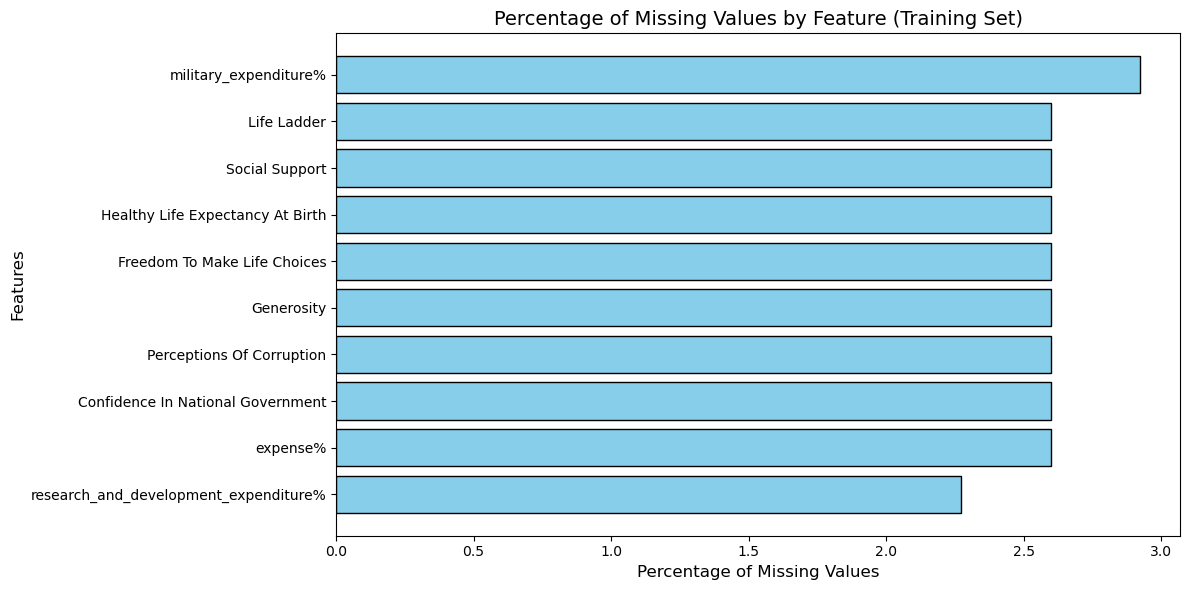

In [23]:
missing_vals_train = X_train.isnull().mean() * 100
missing_vals_train = missing_vals_train[missing_vals_train > 0].sort_values(ascending=False)

# Plot missing values
plt.figure(figsize=(12, 6))
plt.barh(missing_vals_train.index, missing_vals_train.values, color='skyblue', edgecolor='black')
plt.xlabel('Percentage of Missing Values', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Percentage of Missing Values by Feature (Training Set)', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()

In [25]:
#X_train.to_csv("../data/processed/trainset.csv", index=False)

In [47]:
from sklearn.preprocessing import StandardScaler

# Features to exclude from scaling
exclude_features = ['year', 'country']

# Identify features to scale (all columns except those in exclude_features)
features_to_scale = [col for col in X.columns if col not in exclude_features]

# Split the dataset into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training set and transform the training set
X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])

# Transform the test set using the fitted scaler
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

# Optional: Display the first few rows of the scaled training set to verify
print("Scaled Training Set:")
print(X_train.head())

print("\nScaled Test Set:")
print(X_test.head())




Scaled Training Set:
        country  year  GDP_per_capita  Life Ladder  Social Support  \
187     Iceland  2012        0.439193     1.426229        1.157908   
366    Slovenia  2015       -0.191989    -0.549599        0.175129   
242  Luxembourg  2012        2.882314     0.757056        0.336109   
116     Estonia  2018       -0.381823    -0.175092        0.573412   
265  Montenegro  2013       -0.984605    -1.261211       -1.916693   

     Healthy Life Expectancy At Birth  Freedom To Make Life Choices  \
187                          0.952951                      0.861826   
366                          0.315239                      0.796628   
242                          0.673953                      0.951297   
116                         -0.093296                      0.718297   
265                         -1.103670                     -2.172127   

     Generosity  Perceptions Of Corruption  Confidence In National Government  \
187    1.650333                   0.334421        

In [51]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit the encoder on the 'country' column from the training set
X_train['country'] = label_encoder.fit_transform(X_train['country'])

# Transform the 'country' column in the test set using the fitted encoder
X_test['country'] = label_encoder.transform(X_test['country'])

# Optional: Display the mapping of original country names to encoded values
country_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Country Mapping:")
print(country_mapping)


Country Mapping:
{'Albania': 0, 'Austria': 1, 'Belgium': 2, 'Bulgaria': 3, 'Croatia': 4, 'Cyprus': 5, 'Czechia': 6, 'Denmark': 7, 'Estonia': 8, 'Finland': 9, 'France': 10, 'Georgia': 11, 'Germany': 12, 'Greece': 13, 'Hungary': 14, 'Iceland': 15, 'Ireland': 16, 'Italy': 17, 'Latvia': 18, 'Lithuania': 19, 'Luxembourg': 20, 'Montenegro': 21, 'Netherlands': 22, 'North Macedonia': 23, 'Norway': 24, 'Poland': 25, 'Portugal': 26, 'Romania': 27, 'Serbia': 28, 'Slovenia': 29, 'Spain': 30, 'Sweden': 31, 'Switzerland': 32, 'Ukraine': 33, 'United Kingdom': 34}


In [53]:
X_train.head()

,country,year,GDP_per_capita,Life Ladder,Social Support,Healthy Life Expectancy At Birth,Freedom To Make Life Choices,Generosity,Perceptions Of Corruption,Confidence In National Government,...,government_health_expenditure%,birth_rate,death_rate,population,voice_and_accountability_estimate,intentional_homicides,Corruption,Corruption: Bribery,Fraud,Money laundering
187,15,2012,0.439193,1.426229,1.157908,0.952951,0.861826,1.650333,0.334421,-0.891476,...,0.675147,2.517429,-1.678376,-0.744222,0.930326,-0.683932,-0.461951,-0.434675,-0.515535,-0.375386
366,29,2015,-0.191989,-0.549599,0.175129,0.315239,0.796628,0.181799,0.872951,-1.217030,...,0.506967,-0.165139,-0.415333,-0.663388,0.074187,-0.152145,-0.461951,-0.434675,-0.515535,-0.375386
242,20,2012,2.882314,0.757056,0.336109,0.673953,0.951297,0.467680,-1.099777,2.001382,...,-0.072862,0.685431,-1.245332,-0.734471,1.318783,-0.938978,-0.461951,-0.434675,-0.515535,-0.375386
116,8,2018,-0.381823,-0.175092,0.573412,-0.093296,0.718297,-0.759614,-0.221422,0.077303,...,0.110805,0.423717,0.414667,-0.697782,0.455742,0.794723,0.416347,2.080665,-0.269592,0.074420
265,21,2013,-0.984605,-1.261211,-1.916693,-1.103670,-2.172127,-0.979664,0.071575,-0.089054,...,0.093706,1.143431,-0.451420,-0.730285,-1.443516,0.352372,-0.461951,-0.434675,-0.515535,-0.375386


In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Train and evaluate Random Forest
def train_random_forest(X_train, X_test, y_train, y_test, n_estimators=100, max_depth=None):
    """
    Trains a Random Forest model and evaluates it.

    Parameters:
        X_train (pd.DataFrame): Training predictors.
        X_test (pd.DataFrame): Testing predictors.
        y_train (pd.Series): Training target.
        y_test (pd.Series): Testing target.
        n_estimators (int): Number of trees in the forest.
        max_depth (int): Maximum depth of the trees.

    Returns:
        model: Trained Random Forest model.
    """
    # Initialize the model
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R^2 Score: {r2:.4f}")

    return model

# Example Usage
# Load the dataset (ensure target_column is specified correctly)
target_column = 'Corruption Perceptions Index Score'  # Replace with your target column name
# Train and evaluate the Random Forest
model = train_random_forest(X_train, X_test, y_train, y_test, n_estimators=300, max_depth=None)


Mean Squared Error: 3.3740
R^2 Score: 0.9891


In [67]:
X_train.head()

,country,year,GDP_per_capita,Life Ladder,Social Support,Healthy Life Expectancy At Birth,Freedom To Make Life Choices,Generosity,Perceptions Of Corruption,Confidence In National Government,...,government_health_expenditure%,birth_rate,death_rate,population,voice_and_accountability_estimate,intentional_homicides,Corruption,Corruption: Bribery,Fraud,Money laundering
187,15,2012,0.439193,1.426229,1.157908,0.952951,0.861826,1.650333,0.334421,-0.891476,...,0.675147,2.517429,-1.678376,-0.744222,0.930326,-0.683932,-0.461951,-0.434675,-0.515535,-0.375386
366,29,2015,-0.191989,-0.549599,0.175129,0.315239,0.796628,0.181799,0.872951,-1.217030,...,0.506967,-0.165139,-0.415333,-0.663388,0.074187,-0.152145,-0.461951,-0.434675,-0.515535,-0.375386
242,20,2012,2.882314,0.757056,0.336109,0.673953,0.951297,0.467680,-1.099777,2.001382,...,-0.072862,0.685431,-1.245332,-0.734471,1.318783,-0.938978,-0.461951,-0.434675,-0.515535,-0.375386
116,8,2018,-0.381823,-0.175092,0.573412,-0.093296,0.718297,-0.759614,-0.221422,0.077303,...,0.110805,0.423717,0.414667,-0.697782,0.455742,0.794723,0.416347,2.080665,-0.269592,0.074420
265,21,2013,-0.984605,-1.261211,-1.916693,-1.103670,-2.172127,-0.979664,0.071575,-0.089054,...,0.093706,1.143431,-0.451420,-0.730285,-1.443516,0.352372,-0.461951,-0.434675,-0.515535,-0.375386


Generating Correlation Heatmap...


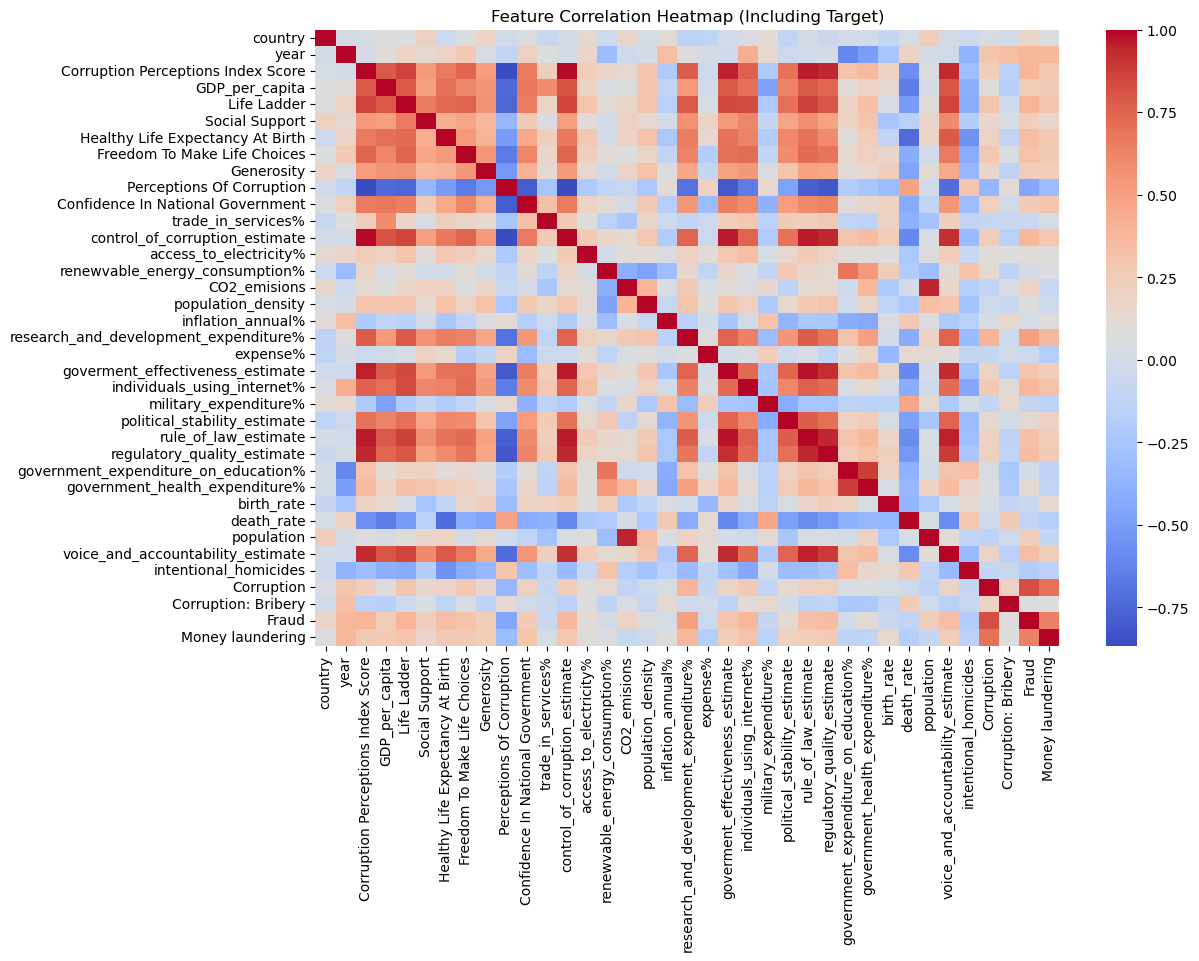


Top Features by Importance:
                                  Feature  Importance
11         control_of_corruption_estimate    0.739255
23                   rule_of_law_estimate    0.233243
30      voice_and_accountability_estimate    0.004925
19       goverment_effectiveness_estimate    0.002152
0                                 country    0.002120
5        Healthy Life Expectancy At Birth    0.001080
8               Perceptions Of Corruption    0.001055
20            individuals_using_internet%    0.001030
6            Freedom To Make Life Choices    0.000938
4                          Social Support    0.000873
31                  intentional_homicides    0.000857
35                       Money laundering    0.000825
25   government_expenditure_on_education%    0.000798
9       Confidence In National Government    0.000787
3                             Life Ladder    0.000767
15                     population_density    0.000644
28                             death_rate    0.000644

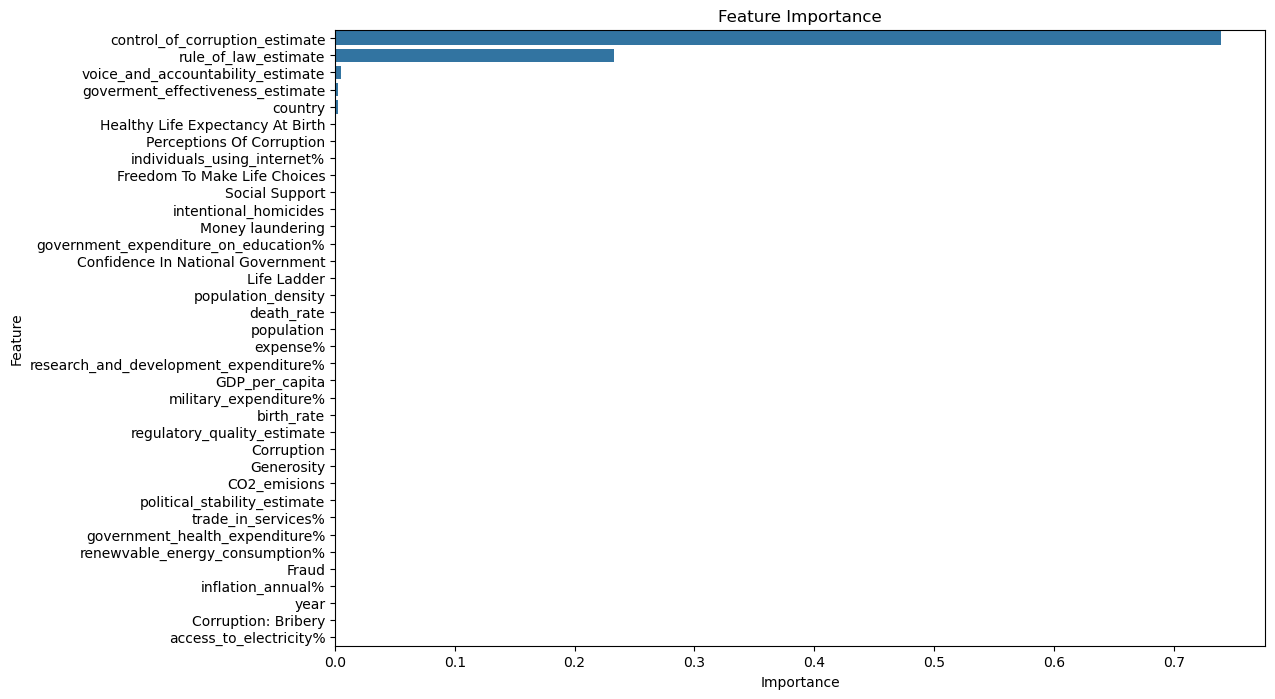

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def feature_analysis_with_model(data, target_column, model, X_train):
    """
    Perform feature analysis using a pre-trained model, including correlation heatmap
    and feature importance visualization.

    Parameters:
        data (pd.DataFrame): The entire dataset (including the target column).
        target_column (str): The name of the target column.
        model: Pre-trained model with feature importance attribute (e.g., Random Forest).
        X_train (pd.DataFrame): Training features used for the model.

    Returns:
        None
    """
    # Correlation Heatmap (Using the Entire Dataset)
    print("Generating Correlation Heatmap...")
    plt.figure(figsize=(12, 8))
    correlation_matrix = data.corr()
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True)
    plt.title("Feature Correlation Heatmap (Including Target)")
    plt.show()

    # Feature Importance from the Pre-Trained Model
    feature_importances = model.feature_importances_
    feature_names = X_train.columns
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    print("\nTop Features by Importance:")
    print(importance_df)

    # Plot Feature Importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

# Example Usage
# Assuming `model` is your trained Random Forest model

data['country'] = label_encoder.transform(data['country'])


feature_analysis_with_model(
    data=data,  # The full dataset
    target_column='Corruption Perceptions Index Score',
    model=model,
    X_train=X_train  # Features used for training the model
)
